# Real-time exposure monitoring (rtxm)
<h3>An R pseudo-package for fitting real-time exposure models</h3>

This pseudo-package provides software for the class of models described in [Houseman and Virji (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5712446/), *A Bayesian Approach for Summarizing and Modeling Time-Series Exposure Data with Left Censoring*.

In particular, the software fits the following model:

\begin{equation}
Y_{ir} = \alpha (task_{ir}) + \mathbf{\mathrm{x}}_{ir}^t \mathbf{\beta}+f_{i}(time_{ir})+\varepsilon_{ir}
\end{equation}

where $i$ indexes a subject (e.g. an employee), $r$ indexes a sequential measurement within the profile corresponding to subject $i$, $Y_{ir}$ is the measured value (or its logarithm), measured at time $time_{ir}$, $\alpha (task_{ir})$ is the conditional mean of the task being performed at $time_{ir}$ (one of a set of finite tasks), $f_{i}(t)$ is a subject-specific trajectory accounting for nonstationary temporal autocorrelation across the time period, and $\varepsilon_{ir}$ is a additional error term whose variance depends on the task being performed (i.e. $task_{ir}$). Note that $Y_{ir}$ may be left-censored (i.e. subject to detection limits).  In this model, $f_{i}(t)$ is realized using an appropriately regularized B-spline representation.  See the published paper for details.

The method has been used in [Virji, Liang et al. (2019)](https://academic.oup.com/annweh/advance-article-pdf/doi/10.1093/annweh/wxz043/28761303/wxz043.pdf), *Peaks, Means, and Determinants of Real-Time TVOC Exposures Associated with Cleaning and Disinfecting Tasks in Healthcare Settings*.

A release of the current version can be found [here](https://github.com/eahouseman/rtxm).  In particular, the read-me for the current release can be found [here](https://github.com/eahouseman/rtxm/blob/master/README.md).  
This notebook demonstrates in detail Example 4 of the release.

In [1]:
#####################################################################
# EXAMPLE 4 (2017 March 7)
#
# This demonstrates the basic model (nondetects, covariates)
#####################################################################

# Change working directory to an appropriate location
setwd('C:\\Users\\eahou\\Documents\\Virji\\rtxm')

source("rtxm.R") # Load the package

Warning message:
"package 'rjags' was built under R version 3.6.1"Loading required package: coda
Warning message:
"package 'coda' was built under R version 3.6.1"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


The code block above simply sets the working directory, which should already contain the sample data set and all of the .R code files, extracted from the zip-file provided in the release.  It then loads the functions that comprise the pseudo-package.  Please note, you may need to first install the R libraries such as [*rjags*](https://cran.r-project.org/web/packages/rjags/rjags.pdf).  Note also that *rjags* requires the installation of the [JAGS software](http://mcmc-jags.sourceforge.net/), which implements Markov-Chain-Monte-Carlo (MCMC) sampling for Bayesian models.

The code block below simply reads in the sample data set (a nano-particle data set) and constructs the "subjects" as location/day combinations (located in `theData$Profile` after the code has run).

In [2]:
###################################################
# Read data
load("rtxmSampleData.RData")
theData <- sample_data

# View the first few rows
head(sample_data)

###################################################
#  Get time data and create "time/employee" profiles
#    Note:  to understand the second argument, 
#           see help for base function "strptime"
theDataDateTime <- rtxmParseDateTime(theData$DateTime, "%d%b%Y:%H:%M:%S")
head(theDataDateTime)

# Concatenated location / sample date 
#  (will function as a "profile" for this example)
theData$Profile <- paste(theData$Location, theDataDateTime$date, sep=":")
print(head(theData$Profile))

TaskID,Location,DateTime,Source_enclosure,lnY,Material,Material_form,Volume,Var1,Var2,Var3
Task3,Location2,15MAR2016:09:42:39,Yes,4.475609,Mat2,MatForm2,49,yes,2,No
Task3,Location2,15MAR2016:09:45:39,Yes,4.293304,Mat2,MatForm2,49,yes,2,No
Task3,Location2,15MAR2016:09:48:39,Yes,4.451700,Mat2,MatForm2,49,yes,2,No
Task3,Location2,15MAR2016:09:51:39,Yes,4.785629,Mat2,MatForm2,49,yes,2,No
Task3,Location2,15MAR2016:09:54:39,Yes,5.176517,Mat2,MatForm2,49,yes,2,No
Task4,Location2,15MAR2016:09:57:39,Yes,5.545958,Mat4,MatForm2,36,yes,2,No


date,day.year,day.month,day.monthDay,day.yearDay,time.days
2016-3-15,2016,2,15,74,0.4046181
2016-3-15,2016,2,15,74,0.4067014
2016-3-15,2016,2,15,74,0.4087847
2016-3-15,2016,2,15,74,0.4108681
2016-3-15,2016,2,15,74,0.4129514
2016-3-15,2016,2,15,74,0.4150347


[1] "Location2:2016-3-15" "Location2:2016-3-15" "Location2:2016-3-15"
[4] "Location2:2016-3-15" "Location2:2016-3-15" "Location2:2016-3-15"


The code below looks for potential duplicate entries and stores them in the object `possDups`.  If any potential duplicates are found, they can be confirmed or deleted (in the latter case they would be removed from possDups).  If there are any duplicate observations that should be removed, `rtxmFixDuplicates` will do that.  This step represents a data cleaning operation, which should be done comprehensively before proceeding.

Next, `rtxmMakeBspline` creates a spline basis (saved in `theSplineBasis`) by setting 8 spline knots for every hour in the range of time considered over the entire analysis.

Finally, for this sample analysis, we create some 'fake' non-detect data by left-censoring values under 25 ppm.  (Note that the data will be analyzed on the log scale, so we define the detection limit on the log scale.)

In [3]:
###################################################
# Fix duplicates

# These are possile duplicates, as judged by their having the same
#  time stamp and reading values
possDups <- rtxmFindDuplicates(theData$lnY, theData$Profile, theDataDateTime$time.days)
print(possDups)

# Remove duplicates (would fix if there were duplicates)
theData <- rtxmFixDuplicates(possDups, theData)

###################################################
#  Create spline basis
#  (B-spline basis with knots based on quantiles obtained by
#    attempting to place 8 knots per hour in the support of the time distribution)
theSplineBasis <- rtxmMakeBspline(theDataDateTime$time.days, 8)

###################################################
#  Fake non-detect data
MY.LOD <- log(25)
theData$lnYND <- pmax(MY.LOD, theData$lnY)


list()


Warning message in rtxmFixDuplicates(possDups, theData):
"There are no duplicates to fix!"

Now we *define* the model.  This does not generate any MCMC estimates yet, it just sets up the necessary data structures. Pay close attention to the names of the arguments and how they are specified.  Note that several of the arguments take formula objects, beginning with `~`.

After defining the model, we do some preliminary 'burn-in' sampling in order to ensure that the MCMC sampler is within the the support of the posterior distribution.

In [4]:
###################################################
#  Create model object
myModel <- rtxmBasicLODCovariatesModel(
  ~lnYND,                                 # Response (Y) 
  ~TaskID,                                # Task (factor variable)
  theSplineBasis,                         # Spline basis object (see above)
  LOD=MY.LOD,                             # LOD (on same scale as Y)
  zCovariates=~Source_enclosure+Volume,   # Covariate model
  data=theData,                           # Data set to interpret variables
  gGroup=~Profile                         # Series (profile) identifier
)

# Burn-in samples
update(myModel,500)  # Adaptation
update(myModel,5000)  # Burn-in

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 158
   Unobserved stochastic nodes: 212
   Total graph size: 13353

Initializing model

500 TRUE 


The next two blocks of code simply report some of the information currently contained in the data structure, including the JAGS model that underlies the sampling.

In [5]:
# Print the model object
print(myModel)

Basic Model for real-time exposure monitoring
(Nondetects, covariates) 

Observations: 168 
Tasks: 5 
Profiles: 3 

Hyperparameters:
 BETAPRECISION BETA0PRECISION    XIPRECISION 
         1e-04          1e-04          1e-04 

Spline basis functions: 63 
Spline boundary: 0 1 
Knots: n=60, density in support: 8 per hour

Limit-of-detection: 3.218876 
Percent non-detect: 6 

Local file containing model definition: C:\Users\eahou\AppData\Local\Temp\RtmpKyt2t9\fileb205162144d 

Markov-Chain Monte-Carlo status: adapted/burn-in 
Markov-Chain Monte-Carlo burn-in: 5000 


In [6]:
# Show the underlying JAGS model
showJAGS(myModel)

model{
        tauZ ~ dnorm(0,1.0E-6)T(0,1.0E10)

        beta0 ~ dnorm(0,BETA0PRECISION)

        for(it in 1:Nprofile){
          for(j in 1:D){
            zeta[it,j] ~ dnorm(0, tauZ)
          }
        }

        for(h in 1:Nsample){
          muTimedep[h] <- inprod(spline[h,1:D],zeta[idProfile[h],1:D])
          muExtra[h] <- inprod(covariates[h,1:nCovariates], xi[1:nCovariates])
          muTask[h] <-  beta0 + inprod(task[h,1:P],beta[1:P])
          mu[h] <-  muTimedep[h] + muTask[h] + muExtra[h]
        }

        for(g1 in 1:NDetect){
          yDetect[g1] ~ dnorm(mu[detectIndex[g1]], tauE[idTask[detectIndex[g1]]])
        }

        for(g0 in 1:NnonDetect){
          yNonDetect[g0] ~ dnorm(mu[nonDetectIndex[g0]], tauE[idTask[nonDetectIndex[g0]]])
          isDetectND[g0] ~ dinterval(yNonDetect[g0] , DETECTLIMIT)
        }

        for(l in 1:P){
          beta[l] ~ dnorm(0,BETAPRECISION)
        }

        for(r in 1:nCovariates){
          xi[r] ~ dnorm(0,XIPRECISION)
      

Now we conduct the MCMC sampling with an intent to keep every 10th sample of 10,000 samples total (so 1000 samples will be stored).  It might be a good idea to conduct a test run with just a few samples to get a sense of how long it will take to generate all the desired samples.  Note that when the object is printed out, it describes the entire sampling history.  It is possible to access earlier samples, but by default the `summary`, `predict`, and `plot` methods will use only the most recent run.

In [7]:
###################################################
#  Collect MCMC samples

system.time( update(myModel,100,"$standard",10) ) # Test run with 100
myModel

update(myModel,10000,"$standard",10) # 10000 samples thinned by 10
myModel

NOTE: Stopping adaptation




   user  system elapsed 
   0.23    0.00    0.23 

Basic Model for real-time exposure monitoring
(Nondetects, covariates) 

Observations: 168 
Tasks: 5 
Profiles: 3 

Hyperparameters:
 BETAPRECISION BETA0PRECISION    XIPRECISION 
         1e-04          1e-04          1e-04 

Spline basis functions: 63 
Spline boundary: 0 1 
Knots: n=60, density in support: 8 per hour

Limit-of-detection: 3.218876 
Percent non-detect: 6 

Local file containing model definition: C:\Users\eahou\AppData\Local\Temp\RtmpKyt2t9\fileb205162144d 

Markov-Chain Monte-Carlo status: sampling block 1 
Markov-Chain Monte-Carlo burn-in: 5000 

Sample history:
    N thin                    variables
1 100   10 beta,beta0,tauE,tauZ,xi,zeta

Basic Model for real-time exposure monitoring
(Nondetects, covariates) 

Observations: 168 
Tasks: 5 
Profiles: 3 

Hyperparameters:
 BETAPRECISION BETA0PRECISION    XIPRECISION 
         1e-04          1e-04          1e-04 

Spline basis functions: 63 
Spline boundary: 0 1 
Knots: n=60, density in support: 8 per hour

Limit-of-detection: 3.218876 
Percent non-detect: 6 

Local file containing model definition: C:\Users\eahou\AppData\Local\Temp\RtmpKyt2t9\fileb205162144d 

Markov-Chain Monte-Carlo status: sampling block 2 
Markov-Chain Monte-Carlo burn-in: 5000 

Sample history:
      N thin                    variables
1   100   10 beta,beta0,tauE,tauZ,xi,zeta
2 10000   10 beta,beta0,tauE,tauZ,xi,zeta

Next, we use the `summary` method to print a "traditional" regression table for the fixed effects, as well as summary statistics of other parameters of interest.  We can also use the `predict` method to get predictions (and 95% credible intervals) for every observation in the data set.  The next two blocks of code demonstrate this.

In [8]:
###################################################
# Output and graphics
print(summary(myModel))  # Model summary

$`fixed effects`
                          mean         sd        2.5%        50%      97.5%
(Intercept)         12.1613384 0.40421648 11.24033403 12.1157297 12.8335918
Task2                2.5181765 0.29086023  1.99800084  2.4780227  3.0517491
Task3                2.5583390 0.24780683  2.08136375  2.5659517  3.0204305
Task4                0.1105551 0.09044528 -0.08149507  0.1137282  0.2795096
Task5                5.7699897 0.50527557  4.91895012  5.7162607  6.8226204
Source_enclosureYes  0.2289213 0.15682313 -0.07184830  0.2259491  0.5470405
Volume              -0.2042065 0.01207221 -0.22661339 -0.2016179 -0.1823610

$`task standard deviations`
            2.5%        50%     97.5%
Task1 0.07820079 0.13078181 0.2581514
Task2 0.11262133 0.13209631 0.1554772
Task3 0.02069507 0.03939567 0.1965288
Task4 0.05059859 0.08205619 0.1596526
Task5 0.05491687 0.08351223 0.1573867

$`zeta standard deviation`
     2.5%       50%     97.5% 
0.3036734 0.3833967 0.4838233 



In [9]:
####################
# Predictions
myPredictions <- predict(myModel)

print(dim(myPredictions))
head(myPredictions)

[1] 168   5


mean,sd,2.5%,50%,97.5%
4.454252,0.05943012,4.316162,4.460608,4.546060
4.322658,0.06085362,4.243548,4.309734,4.474536
4.484496,0.05427688,4.411694,4.473375,4.620411
4.803815,0.04991358,4.694604,4.805881,4.887346
5.116490,0.08511769,4.869579,5.138282,5.211429
5.511897,0.06799759,5.377946,5.512086,5.643327


Next we show a prediction plot (expected by observed), with credible intervals for each observation.  It is a good idea to use this plot to make sure the model fit is reasonable.  Note that the blue observations are non-detects (with *observed* set to the detection limit).  Note that some of the available classes allow for variable detection limits.

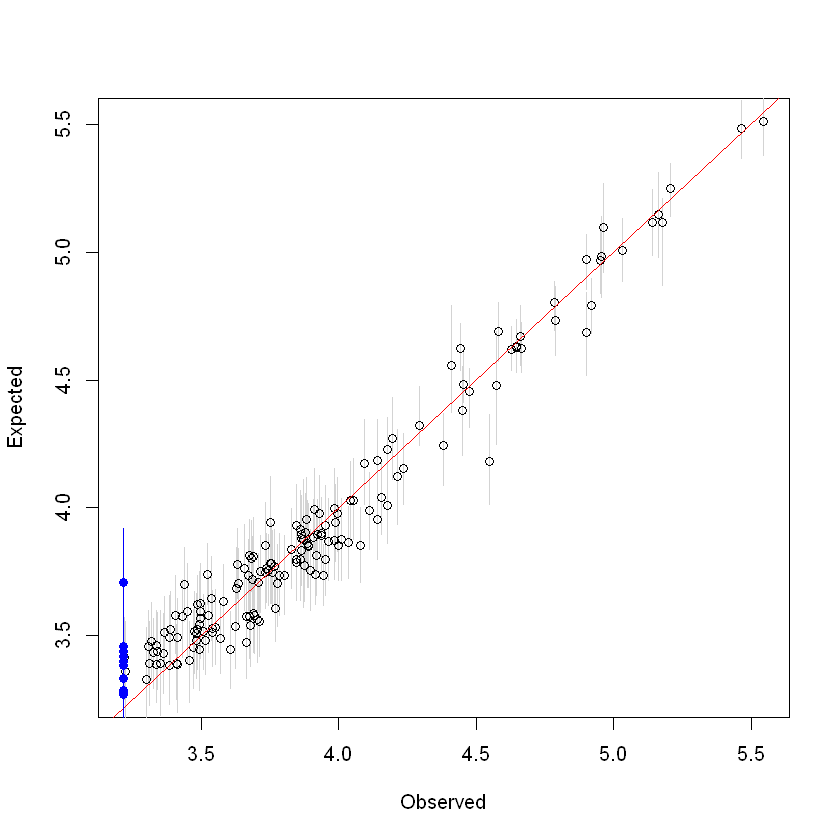

In [10]:
####################
# Prediction plot
plot(myModel, what=".obsvpred")

The blocks of code below show how to generate density plots (i.e. smoothed density estimators for the posterior distributions) for various parameters and derived quantities.

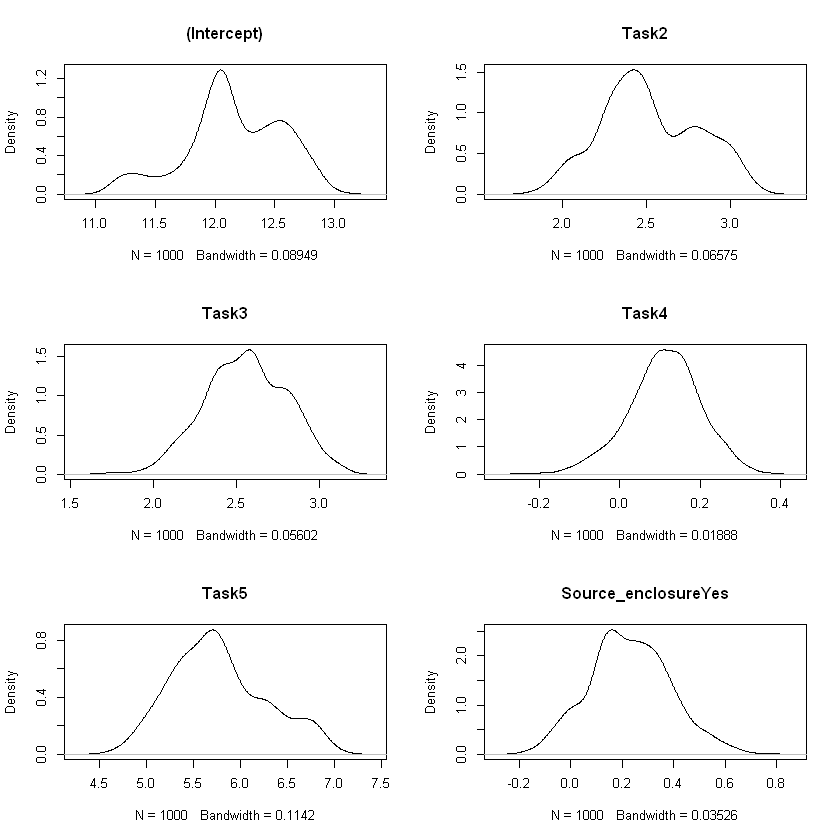

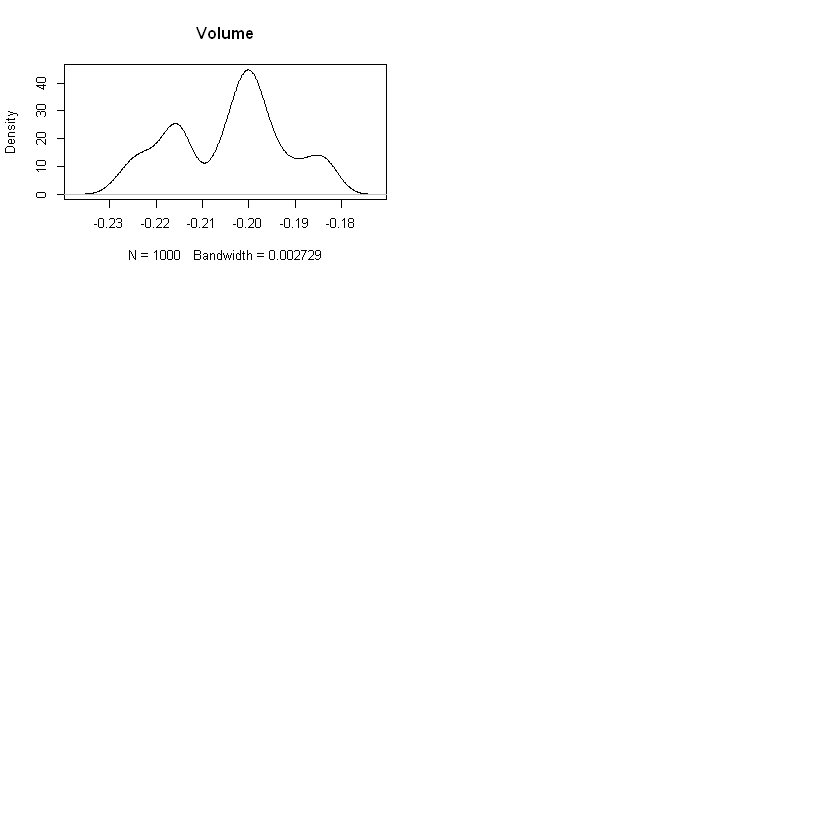

In [11]:
####################
# Density plots

# Fixed-effects coefficients
plot(myModel, what=".density.coefs", panels=c(3,2))

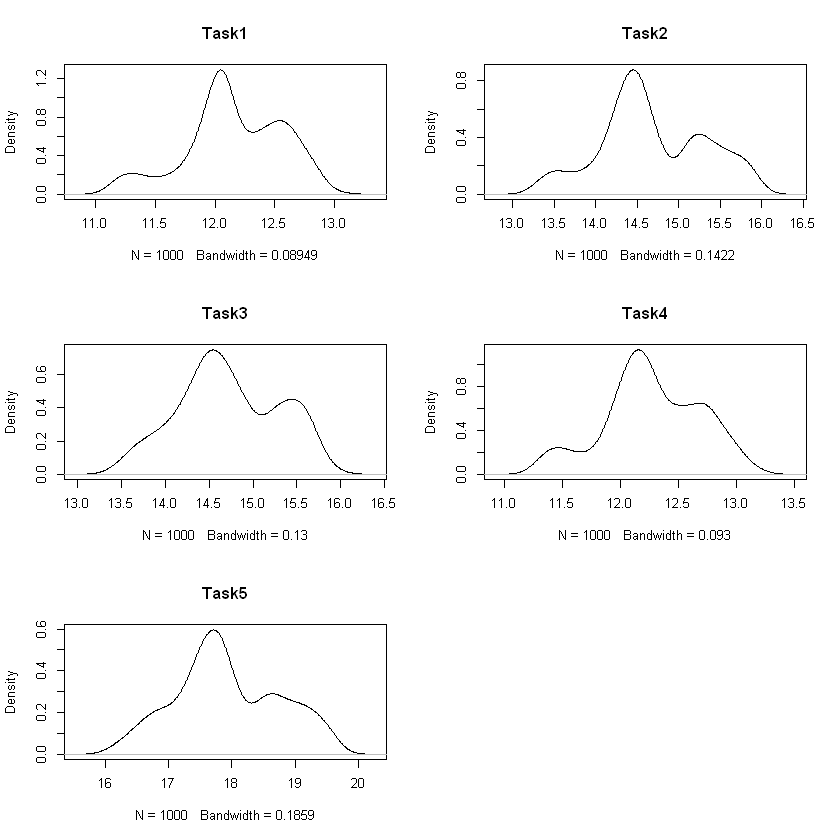

In [12]:
# Task-specific means
plot(myModel, what=".density.tasks", panels=c(3,2))

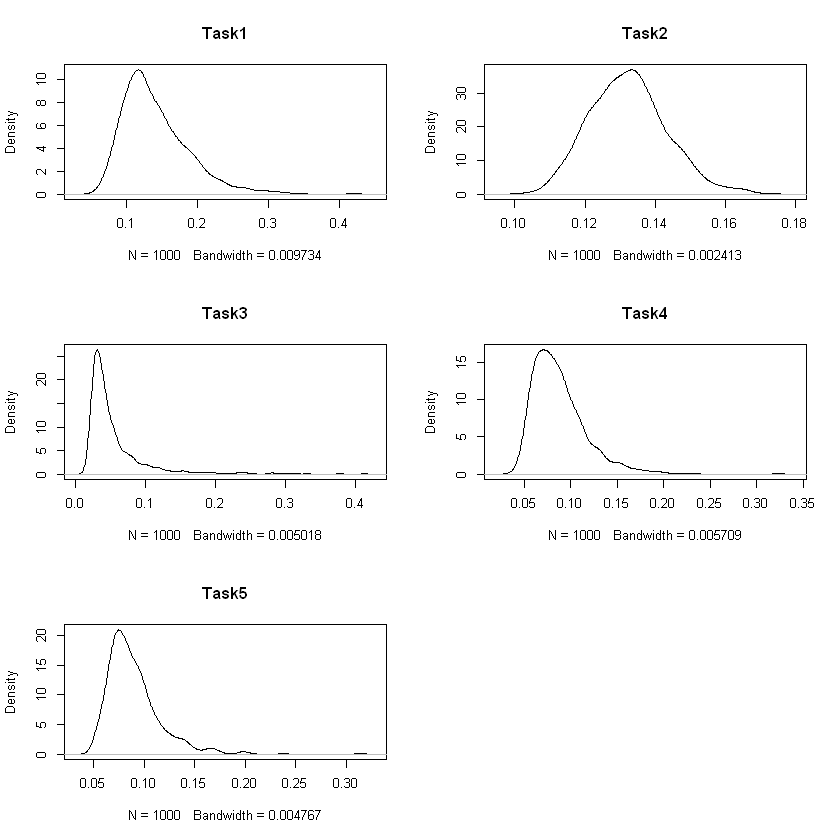

In [13]:
# Task-specific standard deviations
plot(myModel, what=".density.sdEpsilon", panels=c(3,2))

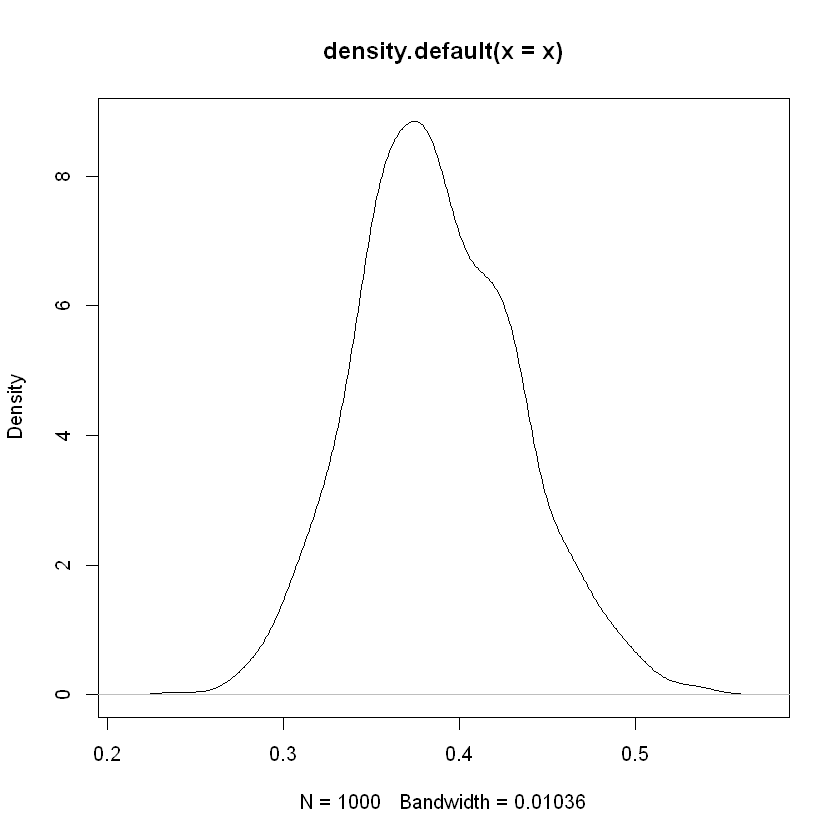

In [14]:
# Standard deviation of the spline coefficients
plot(myModel, what=".density.sdZeta")

The blocks of code below show how to generate trace plots (i.e. the trajectory of the MCMC samples over the entire run) for various parameters and derived quantities.

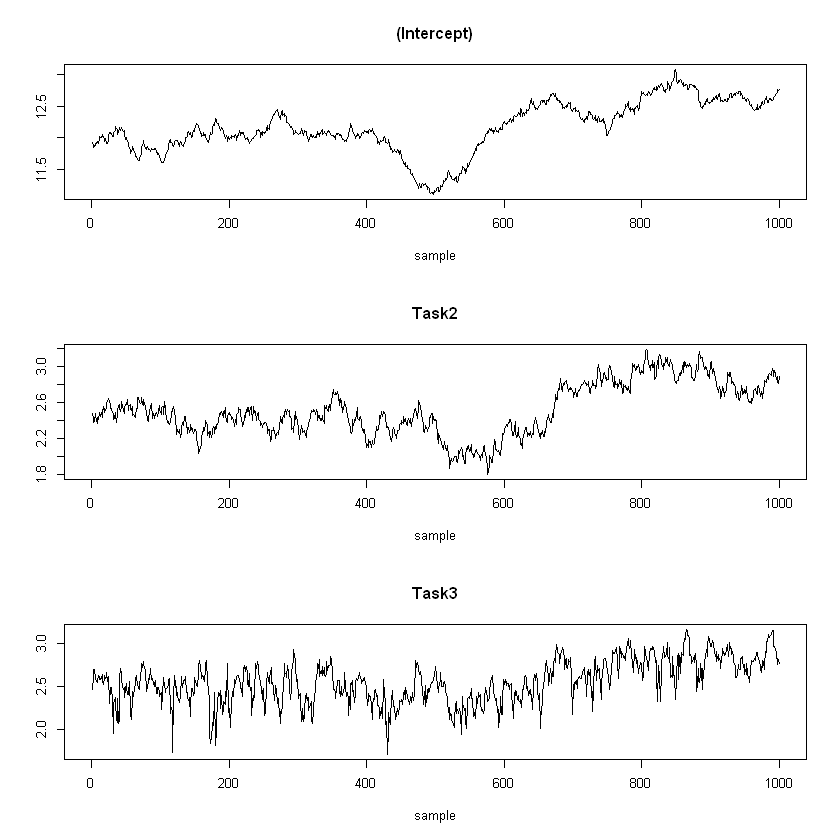

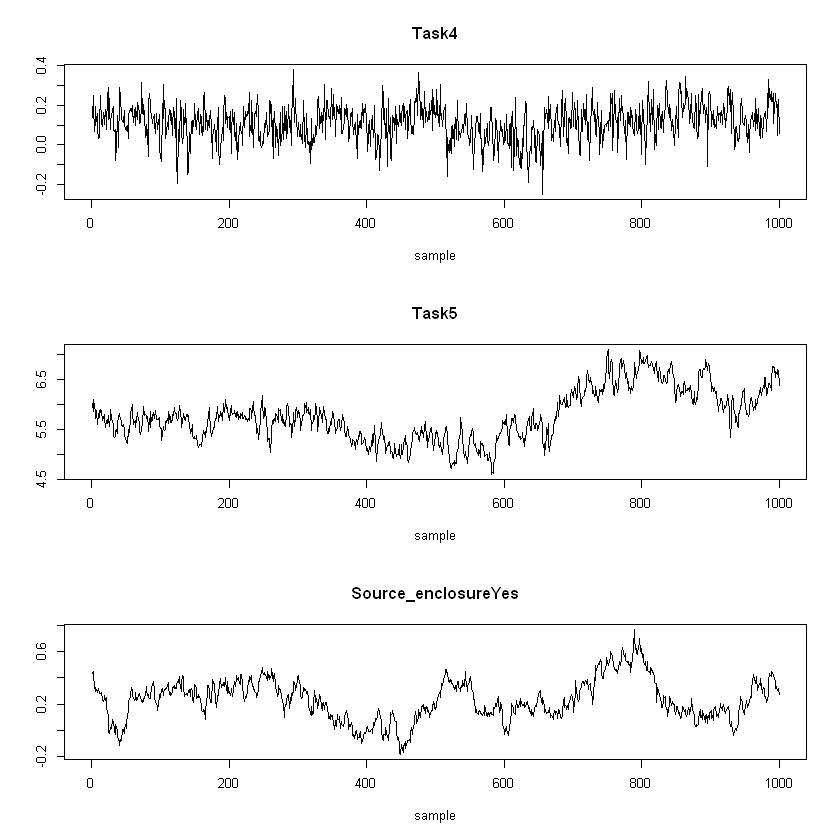

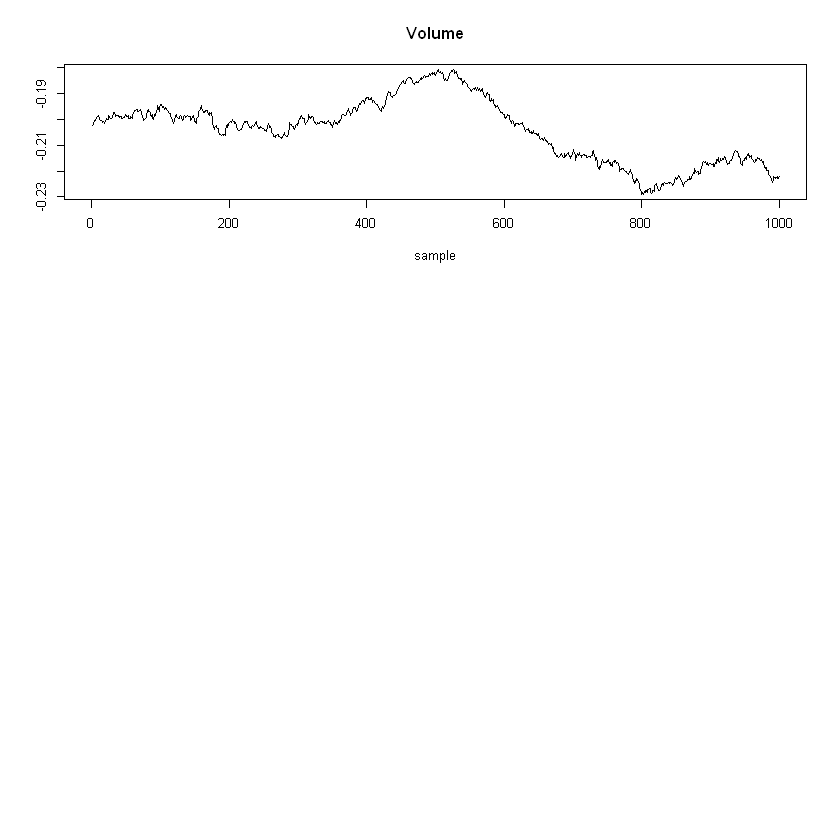

In [15]:
####################
# Trace plots
plot(myModel, what=".trace.coefs")

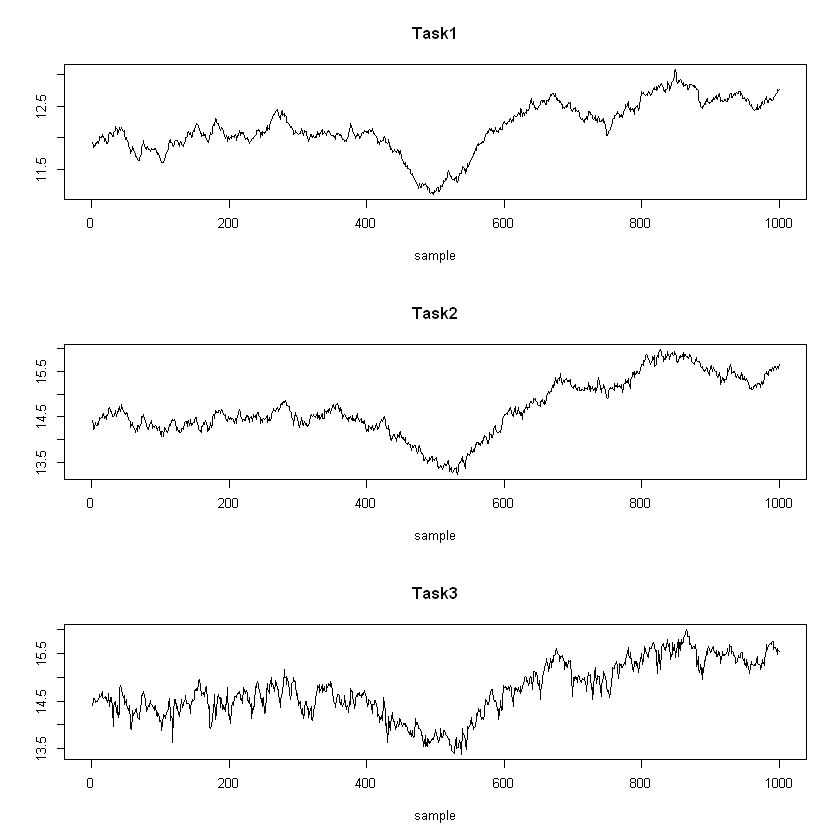

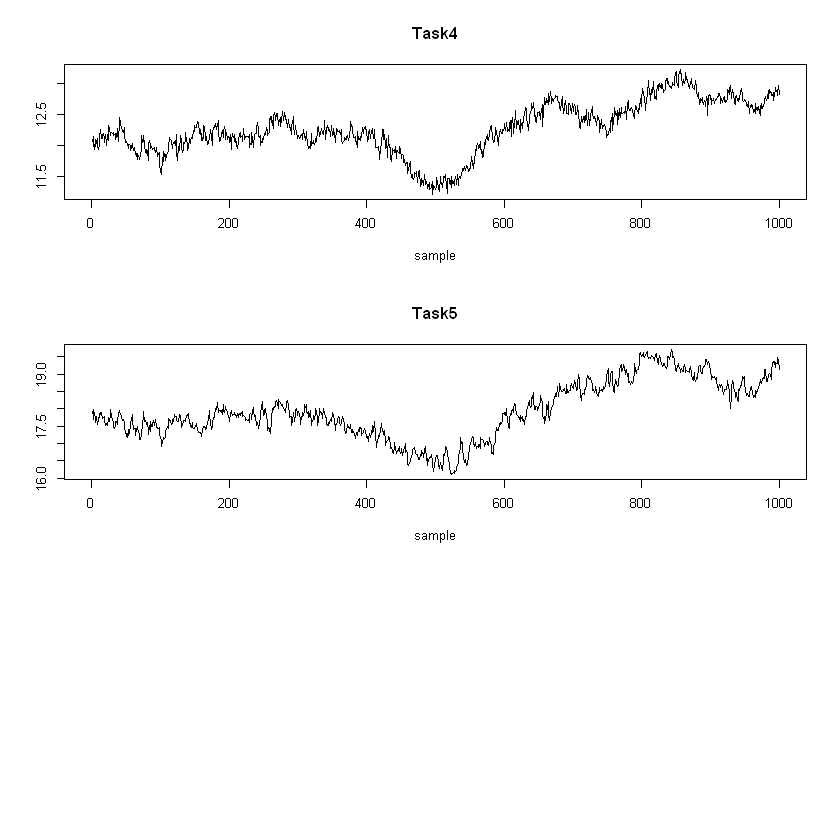

In [16]:
plot(myModel, what=".trace.tasks")

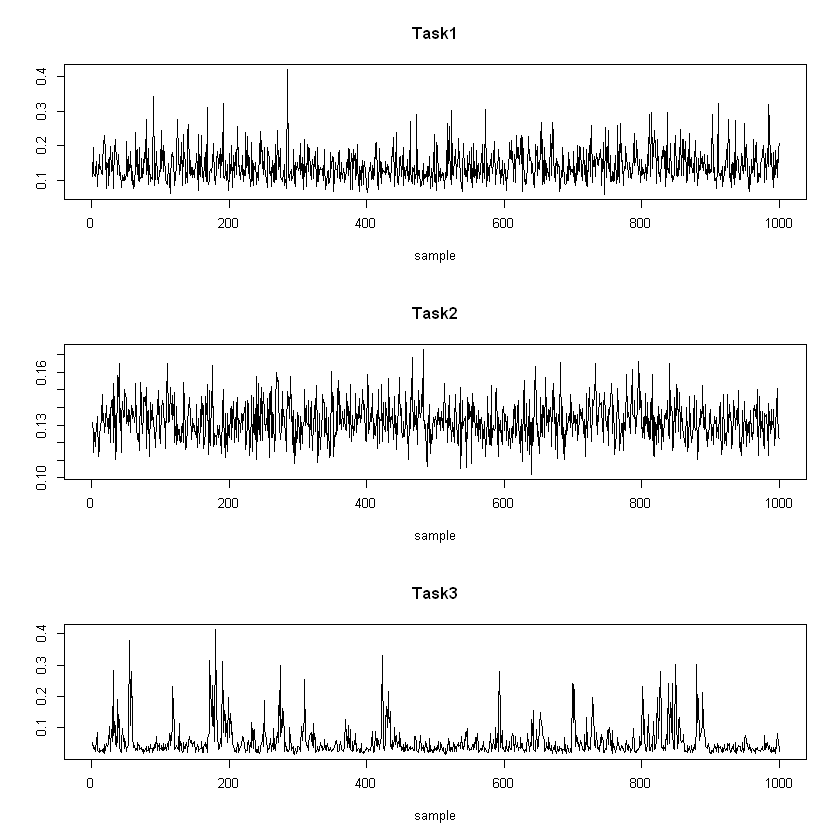

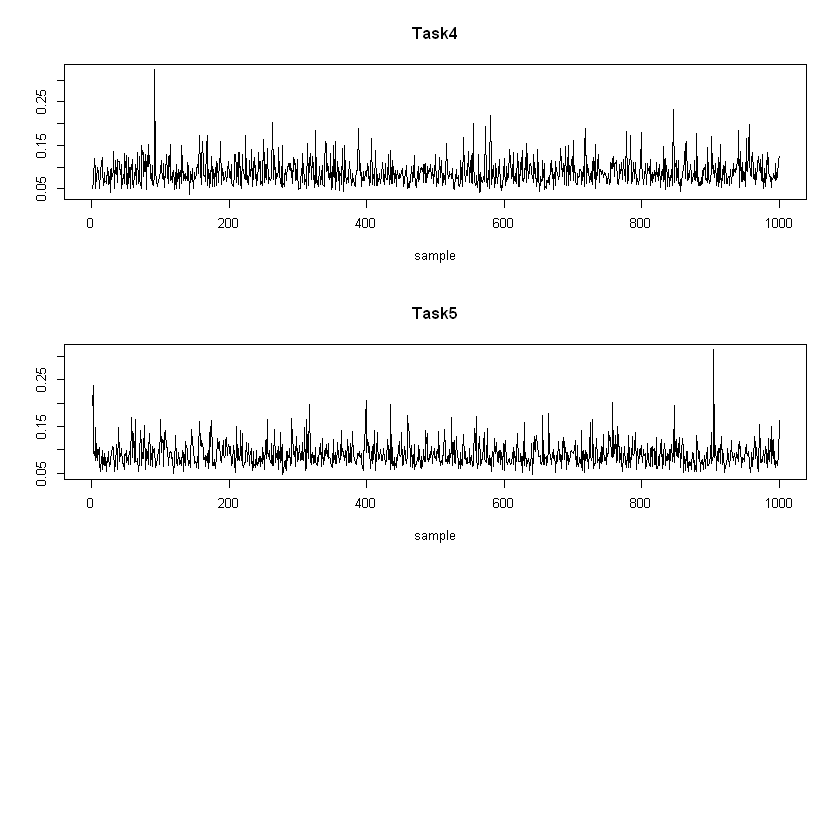

In [17]:
plot(myModel, what=".trace.sdEpsilon")

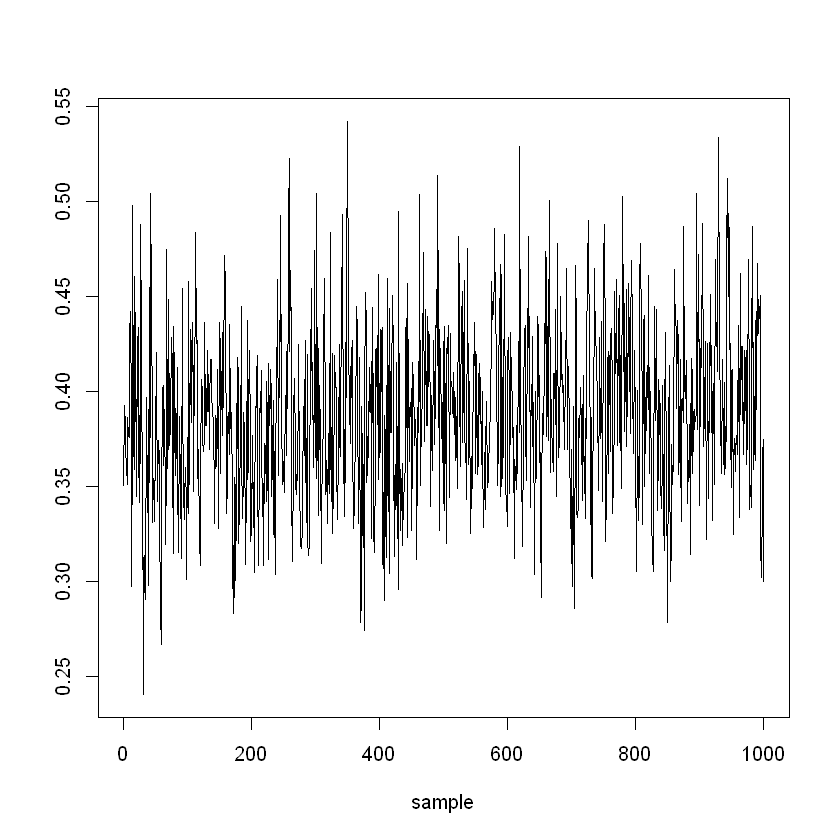

In [18]:
plot(myModel, what=".trace.sdZeta")

**Final note**:  you will notice that some of the trace plots reveal a fair bit of autocorrelation among some of the fixed effects parameters (and their derived task-specific means).  The reason for this is that the design matrix for this run is somewhat ill-conditioned.  This is discussed a bit in the paper.  In general, to avoid this problem, it is a good idea to make sure that the design matrix of fixed effects does not entail too much collinearity.